### Capstone project
Optmization: 
1. Try all the models only using the important features. It turns out both accuracy and Auc became worse
2. Try oversampling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import IPython
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (24,24) #in inches
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize']=13
plt.rcParams['ytick.labelsize']=13
plt.rcParams['legend.fontsize']=13
plt.rcParams['lines.linewidth']=2

In [3]:
cols=["Weight", "TG", "ALT", "GGT", "Glu", "Ultrasound"]
data = pd.read_excel('4304376.f1.xls', usecols=cols)

In [8]:
data.head()

,Weight,ALT,GGT,TG,Glu,Ultrasound
0,72.0,7.0,10.0,1.15,5.00,1
1,74.0,17.0,23.0,1.91,5.74,1
2,81.0,12.0,34.0,0.85,4.63,1
3,70.0,20.0,35.0,1.68,4.95,1
4,75.0,19.0,15.0,0.92,5.57,1


## Split the whole data into train and test sets as 7 : 3

In [4]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data, test_size=0.3, stratify = data.Ultrasound, random_state=42)

In [5]:
print("The size of train_set is: {}".format(train_set.shape[0]))
print("The size of test_set is: {}".format(test_set.shape[0]))

The size of train_set is: 7355
The size of test_set is: 3153


## Seperate features and label columns

In [11]:
label_name = data.columns.tolist()[-1]
def seperate_train_test(dataframe):
    label_name = dataframe.columns.tolist()[-1]
    y = dataframe[label_name]
    X = dataframe.drop(columns = label_name)
    return X, y

In [12]:
X_train, y_train = seperate_train_test(train_set)
X_test, y_test = seperate_train_test(test_set)

In [13]:
y_test.head()

4113    0
6406    0
8719    0
1859    1
7747    0
Name: Ultrasound, dtype: int64

### Generate pipeline

In [14]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [15]:
pro_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [16]:
X_train_prepared = pro_pipeline.fit_transform(X_train)
X_test_prepared = pro_pipeline.transform(X_test)

### Try the model of KNN

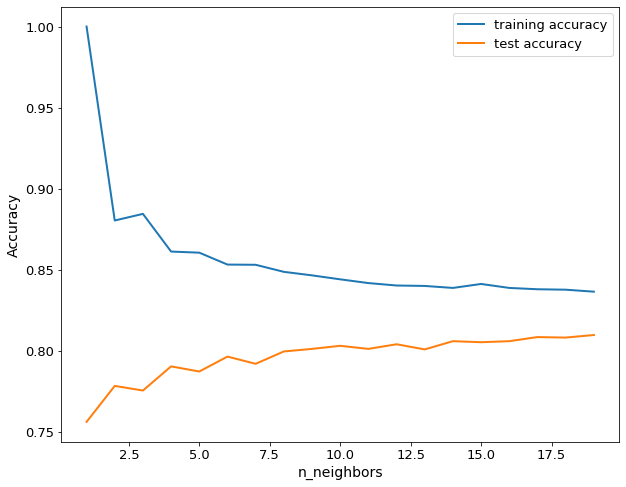

In [34]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
n_neighbors_range = range(1, 20)

for i in n_neighbors_range:
    # build the model
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train_prepared, y_train)
    # record training set accuracy
    training_accuracy.append(knn.score(X_train_prepared, y_train))
    # record generalization accuracy
    test_accuracy.append(knn.score(X_test_prepared, y_test))
plt.figure(figsize = (8, 6))    
plt.plot(n_neighbors_range, training_accuracy, label="training accuracy")
plt.plot(n_neighbors_range, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [41]:
knn = KNeighborsClassifier(n_neighbors = 15)
knn.fit(X_train_prepared, y_train)
print("KNN Training accuracy is: ", knn.score(X_train_prepared, y_train))
print("KNN Testing accuracy is: ", knn.score(X_test_prepared, y_test))

KNN Training accuracy is:  0.8411964649898028
KNN Testing accuracy is:  0.8052648271487473


KNN AUC:  0.8339499121168481


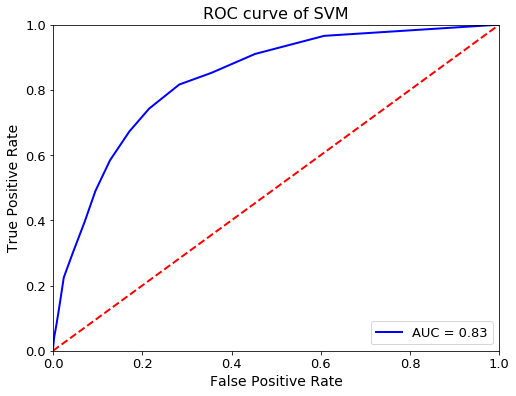

In [58]:
from sklearn import metrics
preds = knn.predict_proba(X_test_prepared)[:,1] # predicted probabilities generated by sklearn classifier
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("KNN AUC: ", roc_auc)

plt.figure(figsize = (8, 6)) 
plt.title('ROC curve of SVM')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Try Naive Bayes modle

In [60]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train_prepared, y_train)
print("NB Training accuracy is: ", nb.score(X_train_prepared, y_train))
print("NB Testing accuracy is: ", nb.score(X_test_prepared, y_test))

NB Training accuracy is:  0.8058463630183549
NB Testing accuracy is:  0.7903583888360292


In [68]:
preds = nb.predict_proba(X_test_prepared)[:,1] # predicted probabilities generated by sklearn classifier
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("NB AUC: ", roc_auc)

NB AUC:  0.8254937776082111


### Try Logistic model

In [61]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=100, penalty="l1")
logreg.fit(X_train_prepared, y_train)
print("Training accuracy is: ", logreg.score(X_train_prepared, y_train))
print("Testing accuracy is: ", logreg.score(X_test_prepared, y_test))

Training accuracy is:  0.8202583276682529
Testing accuracy is:  0.8097050428163654


/Users/pengl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [69]:
preds = logreg.predict_proba(X_test_prepared)[:,1] # predicted probabilities generated by sklearn classifier
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("NB AUC: ", roc_auc)

NB AUC:  0.8453537710362714


## Try SVM

In [62]:
# C=1 IS BEETER THAN C=10
from sklearn.svm import SVC
svm = SVC(kernel = "rbf", C=1, gamma=0.1)
svm.fit(X_train_prepared, y_train)
print("Training accuracy is: ", svm.score(X_train_prepared, y_train))
print("Testing accuracy is: ", svm.score(X_test_prepared, y_test))

Training accuracy is:  0.829775662814412
Testing accuracy is:  0.8150967332699017


In [67]:
# calculate svm auc score
preds = svm.decision_function(X_test_prepared) # predicted probabilities generated by sklearn classifier
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("SVM auc: ", roc_auc)

SVM auc:  0.8036456621890734


In [63]:
# C=1 IS BEETER THAN C=10
from sklearn.svm import LinearSVC
linear_svm = LinearSVC()
linear_svm.fit(X_train_prepared, y_train)
print("Training accuracy is: ", linear_svm.score(X_train_prepared, y_train))
print("Testing accuracy is: ", linear_svm.score(X_test_prepared, y_test))

Training accuracy is:  0.8180829367777023
Testing accuracy is:  0.8087535680304472


/Users/pengl/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Try Decision Tree model

### Add the visualization of decision tree and feature_importances

In [17]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state = 46, max_depth = 5)
tree.fit(X_train_prepared, y_train)
print("Training accuracy is: ", tree.score(X_train_prepared, y_train))
print("Testing accuracy is: ", tree.score(X_test_prepared, y_test))

Training accuracy is:  0.8322229775662815
Testing accuracy is:  0.8103393593403108


In [21]:
from sklearn import metrics
preds = tree.predict_proba(X_test_prepared)[:,1] # predicted probabilities generated by sklearn classifier
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("Tree AUC: ", roc_auc)

Tree AUC:  0.8376234719689134


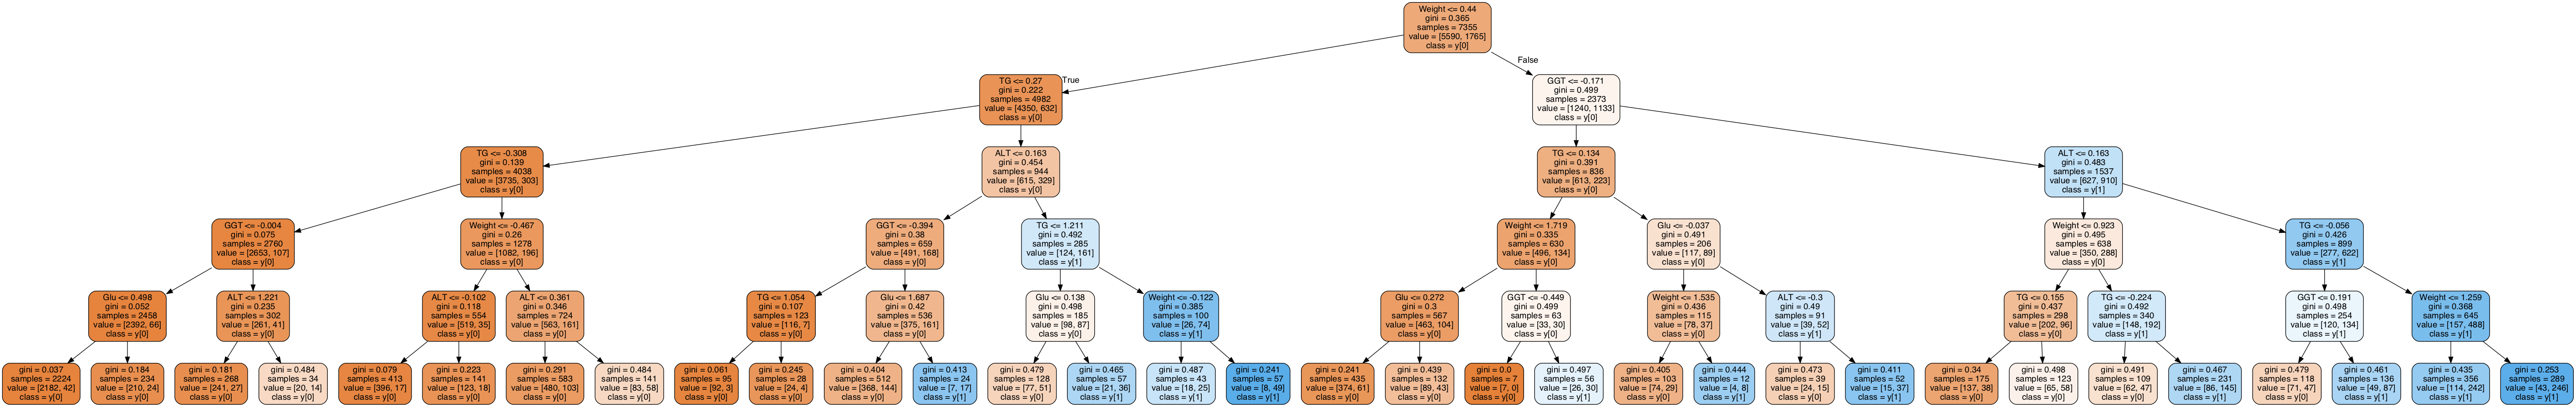

In [24]:
### JAME'S solution
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from IPython.display import Image

class_names = tree.classes_

dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           class_names=True,
                           feature_names=X_train.columns,
                           out_file=None) 

graph = graph_from_dot_data(dot_data) 

Image(graph.create_png()) 

In [317]:
# another method to display tree
from sklearn.tree import export_graphviz

export_graphviz(tree, out_file="NALD_tree.dot", feature_names = X_train.columns,
class_names = ['Yes', "No"], impurity=False, filled=True, rounded=True)

import graphviz

with open("NALD_tree.dot") as f: 
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### Try the random Forest model

In [76]:
from sklearn.ensemble.forest import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100, random_state = 46)
forest.fit(X_train_prepared, y_train)
print("Training accuracy is: ", forest.score(X_train_prepared, y_train))
print("Testing accuracy is: ", forest.score(X_test_prepared, y_test))

Training accuracy is:  1.0
Testing accuracy is:  0.8055819854107199


In [77]:
preds = forest.predict_proba(X_test_prepared)[:,1] # predicted probabilities generated by sklearn classifier
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("Tree AUC: ", roc_auc)

Tree AUC:  0.8440424154744919


In [78]:
important_features = []
for label, feature in zip(X_train.columns, tree.feature_importances_):  ## wrong
    print(label,": ", feature)

Weight :  0.48955695388649845
ALT :  0.11392009187385312
GGT :  0.15442434057330645
TG :  0.21103730250876732
Glu :  0.031061311157574597


### Try GradientBootsting

In [79]:
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(random_state = 0, max_depth =1)
gbrt.fit(X_train_prepared, y_train)
print("Training accuracy is: ", gbrt.score(X_train_prepared, y_train))
print("Testing accuracy is: ", gbrt.score(X_test_prepared, y_test))

Training accuracy is:  0.831407205982325
Testing accuracy is:  0.8160482080558199


In [80]:
preds = gbrt.predict_proba(X_test_prepared)[:,1] # predicted probabilities generated by sklearn classifier
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("Tree AUC: ", roc_auc)

Tree AUC:  0.8564968474538145


### Try gridSearchCV to fine tune parameters of logistic regression

### To prevent information leaking, add the whole pipe into gridSearchCV()

In [81]:
pipe = Pipeline([
    ('process', pro_pipeline),
    ('model', LogisticRegression()),
])

para_grid = [{'model__C': [0.1, 1, 10, 100]}]

In [85]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(pipe, para_grid, cv=10, n_jobs=4)
grid_search.fit(X_train, y_train)  #Note here, do not use X_train_prepared and X_test_prepared

/Users/pengl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('process',
                                        Pipeline(memory=None,
                                                 steps=[('imputer',
                                                         SimpleImputer(add_indicator=False,
                                                                       copy=True,
                                                                       fill_value=None,
                                                                       missing_values=nan,
                                                                       strategy='median',
                                                                       verbose=0)),
                                                        ('scaler',
                                                         StandardScaler(copy=True,
                                            

In [84]:
print("Best accuracy is: ", grid_search.best_score_)
print("Best parameter is: ", grid_search.best_params_)

Best accuracy is:  0.8198504418762746
Best parameter is:  {'model__C': 0.1}


## Testing

In [121]:
knn.predict_proba(X_test_prepared)

array([[0.93333333, 0.06666667],
       [1.        , 0.        ],
       [0.93333333, 0.06666667],
       ...,
       [0.93333333, 0.06666667],
       [1.        , 0.        ],
       [1.        , 0.        ]])

In [122]:
knn.predict(X_test_prepared)

array([0, 0, 0, ..., 0, 0, 0])

## calculate F1 score using function

In [127]:
from sklearn.metrics import f1_score
models = [knn, logreg, nb, svm, tree, forest, gbrt]
model_names = ["knn", "logreg", "nb", "svm", "tree","forest", "gbrt"]
for i in range(len(models)):
    y_pred = models[i].predict(X_test_prepared)
    f1 =f1_score(y_test, y_pred, average='binary')
    print(model_names[i], "F1 score: ", f1)

knn F1 score:  0.5471976401179941
logreg F1 score:  0.5283018867924528
nb F1 score:  0.46992782678428224
svm F1 score:  0.5177832919768404
tree F1 score:  0.5537313432835821
forest F1 score:  0.5455893254262417
gbrt F1 score:  0.5538461538461539


## calculate Auc using function

In [130]:
from sklearn import metrics

models2 = [knn, logreg, nb, tree, forest, gbrt]
model_names2 = ["knn", "logreg", "nb", "tree","forest", "gbrt"]
for i in range(len(models2)):
    preds_p = models2[i].predict_proba(X_test_prepared)[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds_p)
    roc_auc = metrics.auc(fpr, tpr)
    print(model_names2[i], "Auc: ", roc_auc)

knn Auc:  0.8339499121168481
logreg Auc:  0.8453537710362714
nb Auc:  0.8254937776082111
tree Auc:  0.8376234719689134
forest Auc:  0.8440424154744919
gbrt Auc:  0.8564968474538145


In [107]:
f1_score(y_test, y_pred, average='micro')

array([0.8759596 , 0.54719764])

In [110]:
f1_score(y_test, y_pred, average='binary')

0.5471976401179941